In [1]:
# So... need to: 
# - write optimization for E-Step
# - Estimation for M-Step
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.toy.model import PoissonNormalToy

In [3]:
# # xs, lams, ns = model_true.simulate(L)
# sigma2_init = 0.1


# alpha = 0.5
# sigma2 = 2.5
# model_true = PoissonNormalToy(link, alpha, sigma2)

# Ls = [10, 50, 100]
# sims = {}
# num_reps = 10
# for L in Ls:
#     sim_reps = []
#     for rep in range(num_reps):
#         print(f'L = {L}, rep {rep}')
#         xs, lams, ns = model_true.simulate(L)

#         model = PoissonNormalToy(link, alpha, sigma2_init)
#         results = model.estimate_sigma2(ns, 100, optim_type, track=False, print_iter=50)
#         sim_reps.append(results['sigma2_est'])
#     sims[L] = sim_reps



In [4]:
# for L in Ls:
#     lrep = np.ones(num_reps)*L
#     plt.scatter(lrep.mean(), np.array(sims[L]).mean())
#     plt.scatter(lrep.mean(), np.array(sims[L]).mean())

In [54]:
L = 250
alpha = 3
sigma2 = 0


optim_type = 'Newton'
link = 'log'

model_true = PoissonNormalToy(link, alpha, sigma2)
xs, lams, ns = model_true.simulate(L)


Text(0.5, 0, 'n')

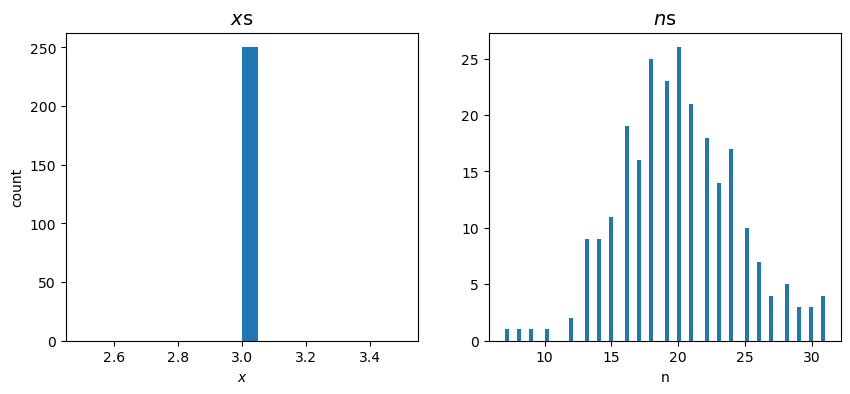

In [55]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(xs, bins=20);
ax[1].hist(ns, bins=80);

ax[0].set_title('$x$s', fontsize=14)
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('count')
# ax[1].set_xlim([0,100])
ax[1].set_title('$n$s', fontsize=14)
ax[1].set_xlabel('n')

In [56]:
R = 500
sigma2_init = 1e-2 
model = PoissonNormalToy(link, alpha, sigma2_init)
results = model.estimate_sigma2(ns, R, optim_type, track=True, print_iter=50)

0
50
100
150
200
250
300
350
400
450


Text(0, 0.5, '$\\hat{\\sigma}^2$')

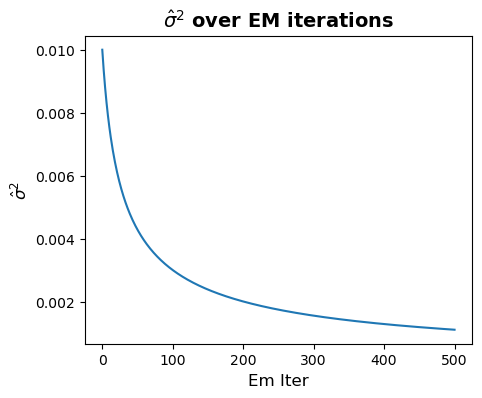

In [57]:
fig, ax = plt.subplots(figsize=(5,4))
iters = np.arange(0,R+1) 
ax.plot(iters, np.concatenate([np.array([sigma2_init]), results['track']['sigma2']]))
# ax.axvline(0.5, color='k')
ax.set_xlabel('Em Iter',fontsize=12)
ax.set_title('$\\hat{\\sigma}^2$ over EM iterations', fontweight='bold',fontsize=14)
ax.set_ylabel('$\\hat{\\sigma}^2$', fontweight='bold', fontsize=12)
# ax.set_xlim([0,10])
# ax.set_xlim([100,1000])
# ax.set_ylim([0.0009,0.0011])
# ax.set_ylim([0.00099,0.0011])


In [43]:
results['sigma2_est']

0.0006797311013109422

In [44]:
from scipy.special import factorial
def compute_CDLL_loglink(xs, ns, alpha, sigma2):
    L = xs.size
    lams = np.exp(xs)
    # A = (ns*np.log(lams) - lams - np.log(factorial(ns))).sum()
    A = (ns*np.log(lams) - lams ).sum()
    B = ((xs-alpha)**2).sum() / sigma2
    C = L*np.log(2*np.pi*sigma2)
    return A - (1/2)*(B + C)

# poissonLL = compute_PoissonLL(ns)
def get_PoissonLL_func(ns):
    def poissonLL(lam):
        # LL = (ns*np.log(lam) - lam - np.log(factorial(ns))).sum()
        LL = (ns*np.log(lam) - lam).sum()
        return LL
    return poissonLL


In [45]:
sigma2_init

0.01

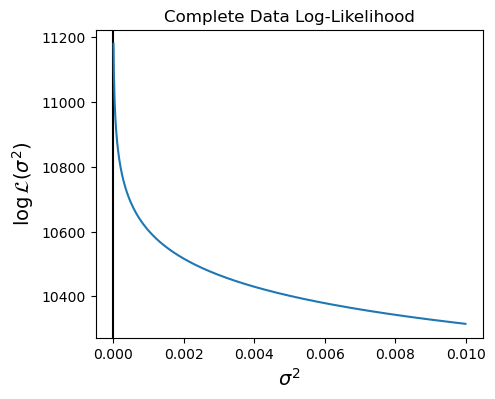

In [58]:
# Gaussian LL
sigma2s = np.arange(1e-5, sigma2_init, 1e-5)
cdll = compute_CDLL_loglink(xs, ns, alpha, sigma2s)
fig, ax = plt.subplots(figsize=(5,4))
ax.axvline(sigma2, color='k')
ax.set_xlabel('$\\sigma^2$', fontweight='bold',fontsize=14)
ax.set_ylabel('$\log \mathcal{L} (\\sigma^2)$', fontweight='bold',fontsize=14)
ax.set_title('Complete Data Log-Likelihood')
ax.plot(sigma2s, cdll)

In [59]:
# track = results['track']

# # rs = np.array([1, 50, 100, 200, 300, 400, 500]) - 1
# rs = np.array([1, 2, 3, 5, 10, 100]) - 1
# for r in rs:
#     x_ests_r = track['x_ests'][:,r]

#     fig,ax = plt.subplots(figsize=(4,4))
#     ax.plot(xs, x_ests_r, '.')
#     ax.set_xlabel('True $x^{\\ell}$', fontsize=12)
#     ax.set_ylabel('$\\hat{x}^{\\ell}$', fontsize=12)
#     ax.set_title('E-Step $\\hat{x}^{\\ell}$ vs True $x$ ' + f'EM Iter {r+1}')
#     # ax.set_xlim([-5,5])
#     # ax.set_ylim([4.5,5.5])

In [60]:
def compute_Q(ns, Ex, Eexpx, Ex2, alpha, sigma2):
    L = Ex.size
    A = (ns*Ex - Eexpx).sum()
    B = (Ex2 - 2*alpha*Ex + alpha**2).sum() / sigma2
    C = np.log(sigma2)
    Qval = A - (1/2)*(A + L*B)
    return Qval


In [61]:
R = 500
track = results['track']
Qs = []

for r in range(1,R):
    sigma2_est_rm1 = track['sigma2'][r]
    x_ests_r = track['x_ests'][:,r]
    x_var_ests_r = track['x_var_ests'][:,r]
    x_sm_r = track['x_sm'][:,r]
    x_exp_r = np.exp(x_ests_r + 0.5*np.sqrt(x_var_ests_r))
    Q = compute_Q(ns, x_ests_r, x_exp_r, x_sm_r, alpha, sigma2_est_rm1)
    Qs.append(Q)

Text(0, 0.5, '$Q^{r+1}$')

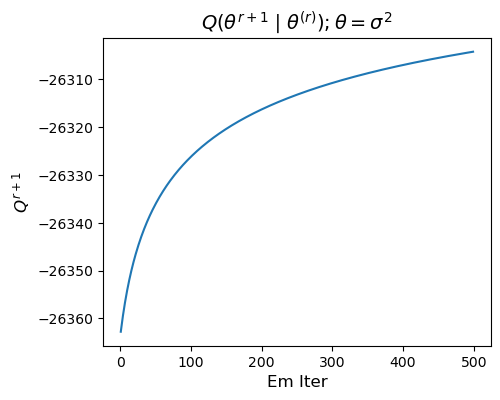

In [62]:
# Gaussian LL
fig, ax = plt.subplots(figsize=(5,4))
iters = np.arange(1,R) 
ax.plot(iters, np.array(Qs))
# ax.axvline(0.5, color='k')
ax.set_xlabel('Em Iter',fontsize=12)
ax.set_title('$Q(\\theta^{r+1} \mid {\\theta}^{(r)}); \\theta = \\sigma^2$', fontweight='bold',fontsize=14)
ax.set_ylabel('$Q^{r+1}$', fontweight='bold', fontsize=12)

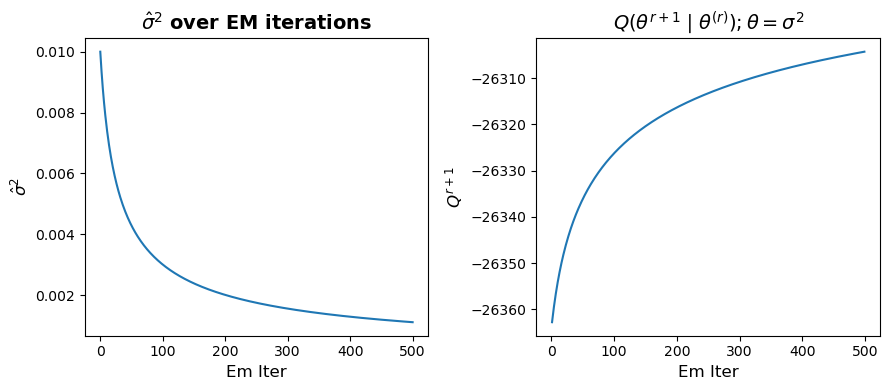

In [63]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
# ax.axvline(0.5, color='k')
iters = np.arange(R+1)
ax[0].plot(iters, np.concatenate([np.array([sigma2_init]), results['track']['sigma2']]))
# ax.axvline(0.5, color='k')
ax[0].set_xlabel('Em Iter',fontsize=12)
ax[0].set_title('$\\hat{\\sigma}^2$ over EM iterations', fontweight='bold',fontsize=14)
ax[0].set_ylabel('$\\hat{\\sigma}^2$', fontweight='bold', fontsize=12)

iters = np.arange(1,R) 
ax[1].plot(iters, np.array(Qs))
ax[1].set_xlabel('Em Iter',fontsize=12)
ax[1].set_title('$Q(\\theta^{r+1} \mid {\\theta}^{(r)}); \\theta = \\sigma^2$', fontweight='bold',fontsize=14)
ax[1].set_ylabel('$Q^{r+1}$', fontweight='bold', fontsize=12)
plt.tight_layout()

In [82]:
def plot_trial_components(n, xs, alpha, sigma2):
    conditional = n*xs - np.exp(xs)
    prior = -(xs-alpha)**2 / sigma2
    posterior = conditional + prior
    plt.plot(xs, prior, label='prior')
    plt.plot(xs, conditional, label='likelihood')
    plt.plot(xs, posterior,label='posterior')
    plt.legend()

Q-function on full model now that working appropriately
Toy model single - frequency 
- use complex!
- jax / stan

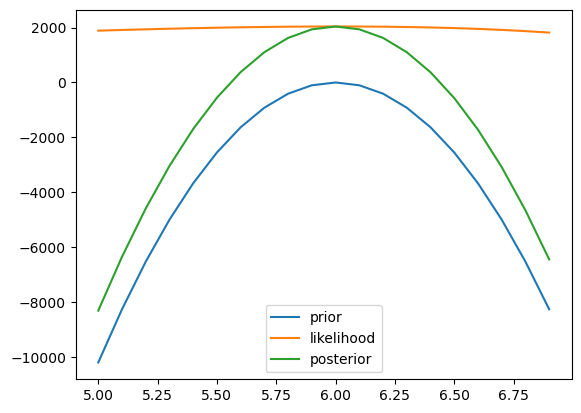

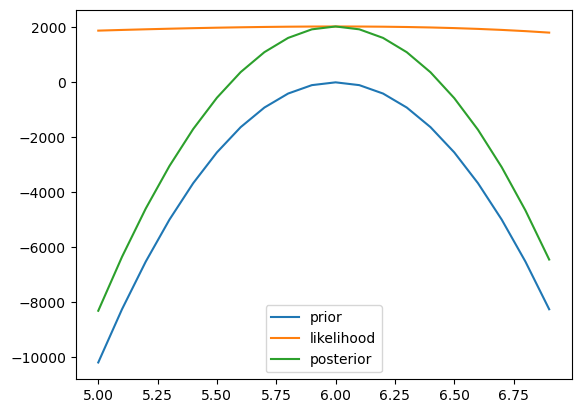

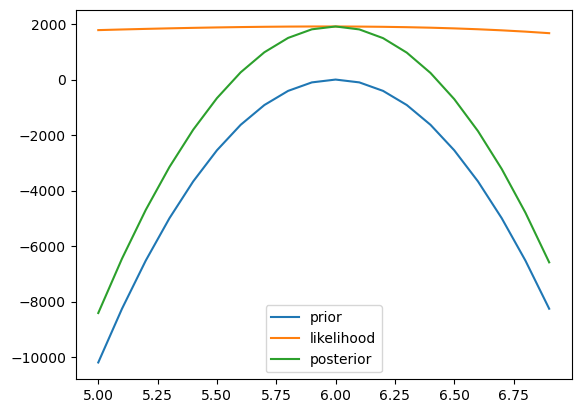

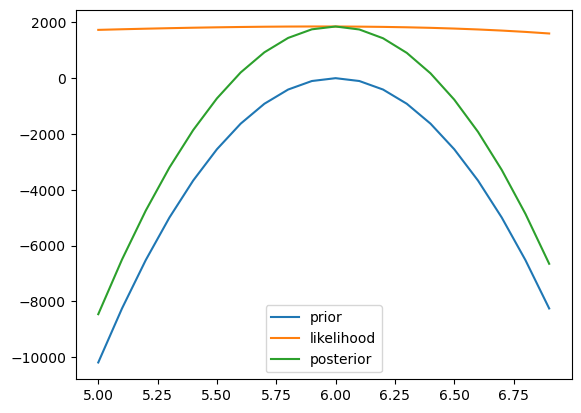

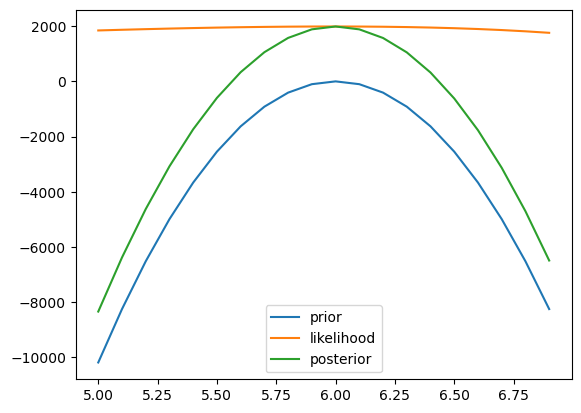

In [84]:
r = 0
l = 0
for l in range(5):
    xs_plot = np.arange(5,7,0.1)
    prior, likelihood, posterior = plot_trial_components(ns[l], xs_plot, alpha, results['track']['sigma2'][r])
    plt.show()

In [208]:
R = 100
track = results['track']
CDLLs = []
for r in range(R):
    # sigma2_r = track['sigma2']
    x_ests_r = track['x_ests'][:,r]
    x_sm_r = track['x_sm'][:,r]
    CDLLfunc = compute_CDLL_idlink(x_ests_r, ns, alpha, sigma2s)
    CDLLs.append(CDLLfunc)

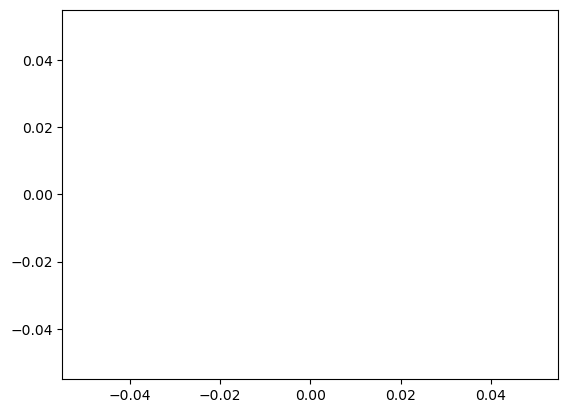

In [209]:
color = plt.cm.rainbow(np.linspace(0, 1, R))
for r in range(100):
    plt.plot(sigma2s, CDLLs[r], color=color[r])

In [137]:
R = 10
sigma2s = np.arange(2.0, 3.0, 0.01)
track = results['track']
Qs = []
for r in range(R):
    # sigma2_est_rm1 = track['sigma2'][r-1]
    x_ests_r = track['x_ests'][:,r]
    x_var_ests_r = track['x_var_ests'][:,r]
    x_sm_r = track['x_sm'][:,r]
    x_exp_r = np.exp(x_ests_r + 0.5*np.sqrt(x_var_ests_r))
    Qfunc = compute_Q(ns, x_ests_r, x_exp_r, x_sm_r, alpha, sigma2s)
    # Qfunc = compute_Q(x_ests_r, x_sm_r, alpha, sigma2s)
    Qs.append(Qfunc)

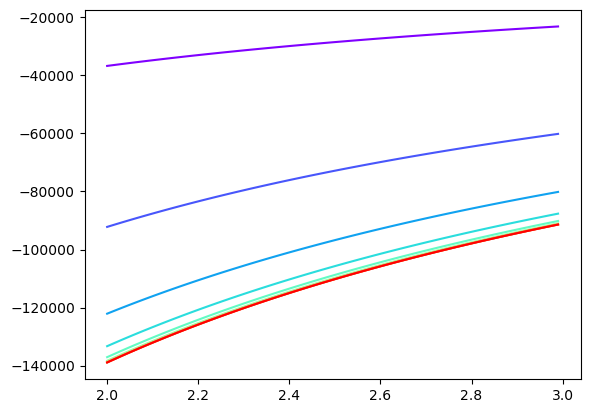

In [139]:
color = plt.cm.rainbow(np.linspace(0, 1, R))
for r in range(R):
    plt.plot(sigma2s, Qs[r], color=color[r])

In [78]:
x_sm = x_ests**2 + x_var_ests

In [84]:
compute_Q(x_ests, x_sm, alpha, 0.5)

-15.726708255877782

In [85]:
test = compute_Q(x_ests, x_sm, alpha, sigma2s)

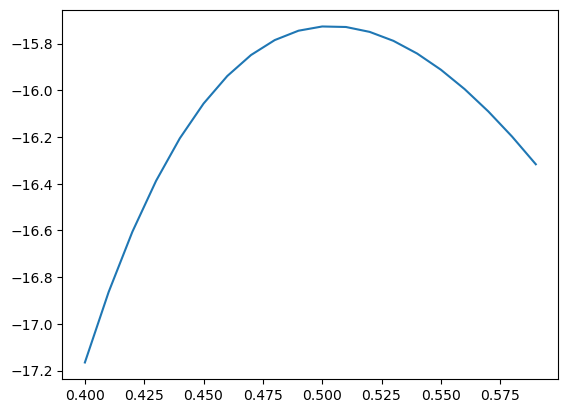

In [88]:
plt.plot(sigma2s, test)

In [82]:
for s in range

array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59])

In [ ]:
def plot_Q(Ex, Ex2, alpha, sigma2_range):


In [76]:
x_ests.size

100

In [72]:
test_update = m_step_idlink(x_ests, x_var_ests, alpha, L_use)

In [73]:
test_update

0.5038406728387504

In [100]:
sig2

0.5

In [ ]:
if self.optim_type == "Newton":
    Result = op.minimize(fun=cost_func_optim, x0=init,
                    jac=cost_grad_optim, hess=cost_hess_optim, method='Newton-CG',
                    options={'maxiter':max_iter, 'disp':False})
elif self.optim_type == "BFGS": 
    Result = op.minimize(fun=cost_func_optim, x0=init,
                    jac=cost_grad_optim, method='BFGS',
                    options={'maxiter':max_iter, 'disp':False})

In [ ]:
ns_idlink = np.random.poisson(xs)
ns_explink = np.random.poisson(np.exp(xs))

(-1.0, 100.0)

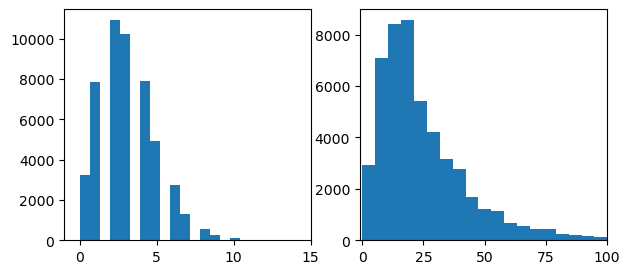

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(7,3))
ax[0].hist(n_idlink, bins=20);
ax[1].hist(n_explink, bins=100);
ax[0].set_xlim([-1,15])
ax[1].set_xlim([-1,100])

In [ ]:
# so - need to choose alpha/sigma2 depending on link function, which we already knew

In [ ]:
l = 0

In [ ]:
ns_idlink = ns

In [ ]:
L_use = 100
x_ests = np.zeros(L_use)
for l in range(L_use):
    cost_func, cost_grad, cost_hess = get_optim_funcs_idlink(ns_idlink[l], alpha, sigma2)
    import scipy.optimize as op
    max_iter = 1000
    init = np.array([1])
    Result = op.minimize(fun=cost_func, x0=init,
                jac=cost_grad, hess=cost_hess, method='Newton-CG',
                options={'maxiter':max_iter, 'disp':False})
    x_ests[l] = Result.x[0]